## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

✓ All libraries imported successfully
TensorFlow version: 2.20.0
Keras version: 3.12.0
GPU Available: []


## 2. Load Preprocessed Data

In [2]:
# Load preprocessed data
data_dir = Path('preprocessed_data')

print("Loading preprocessed data...")
X_train = np.load(data_dir / 'X_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
X_test = np.load(data_dir / 'X_test.npy')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

# Load metadata
with open(data_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"\n✓ Data loaded successfully")
print(f"\nDataset shapes:")
print(f"  Training: X={X_train.shape}, y={y_train.shape}")
print(f"  Validation: X={X_val.shape}, y={y_val.shape}")
print(f"  Test: X={X_test.shape}, y={y_test.shape}")

# Extract metadata
TIMESTEPS = metadata['timesteps']
FEATURES = metadata['features']
NUM_CLASSES = metadata['num_classes']

print(f"\nModel input specifications:")
print(f"  Timesteps: {TIMESTEPS}")
print(f"  Features per timestep: {FEATURES}")
print(f"  Number of classes: {NUM_CLASSES}")

# Activity mapping
activity_mapping = metadata['activity_mapping']
reverse_mapping = {v: k for k, v in activity_mapping.items()}
print(f"\nActivity classes: {list(activity_mapping.keys())}")

Loading preprocessed data...

✓ Data loaded successfully

Dataset shapes:
  Training: X=(5881, 128, 4), y=(5881, 6)
  Validation: X=(1471, 128, 4), y=(1471, 6)
  Test: X=(2947, 128, 4), y=(2947, 6)

Model input specifications:
  Timesteps: 128
  Features per timestep: 4
  Number of classes: 6

Activity classes: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


## 3. Create Results Tracking System

In [3]:
# Create directory for saving models and results
results_dir = Path('training_results')
results_dir.mkdir(exist_ok=True)

models_dir = results_dir / 'models'
models_dir.mkdir(exist_ok=True)

plots_dir = results_dir / 'plots'
plots_dir.mkdir(exist_ok=True)

# Results tracking
training_results = []

def save_training_record(experiment_name, config, history, test_results):
    """Save training configuration and results"""
    record = {
        'experiment_name': experiment_name,
        'configuration': config,
        'training_results': {
            'final_train_accuracy': float(history.history['accuracy'][-1]),
            'final_train_loss': float(history.history['loss'][-1]),
            'final_val_accuracy': float(history.history['val_accuracy'][-1]),
            'final_val_loss': float(history.history['val_loss'][-1]),
            'best_val_accuracy': float(max(history.history['val_accuracy'])),
            'epochs_trained': len(history.history['accuracy'])
        },
        'test_results': test_results
    }
    training_results.append(record)
    return record

print("✓ Results tracking system initialized")

✓ Results tracking system initialized


## 4. Define Model Building Function

In [4]:
def build_lstm_model(lstm_units=64, dense_units=32, dropout_rate=0.3, 
                     learning_rate=0.001, optimizer_name='adam', 
                     use_bidirectional=False, num_lstm_layers=1,
                     l2_reg=0.0):
    """
    Build LSTM model for activity recognition
    
    Parameters:
    - lstm_units: Number of LSTM units
    - dense_units: Number of dense layer units
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for optimizer
    - optimizer_name: 'adam', 'rmsprop', or 'sgd'
    - use_bidirectional: Use Bidirectional LSTM
    - num_lstm_layers: Number of LSTM layers
    - l2_reg: L2 regularization factor
    """
    model = Sequential(name='HAR_LSTM')
    
    # LSTM layers
    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)  # Only last LSTM doesn't return sequences
        
        if use_bidirectional:
            model.add(Bidirectional(
                LSTM(lstm_units, return_sequences=return_sequences, 
                     kernel_regularizer=l2(l2_reg) if l2_reg > 0 else None),
                input_shape=(TIMESTEPS, FEATURES) if i == 0 else None
            ))
        else:
            model.add(LSTM(
                lstm_units, return_sequences=return_sequences,
                kernel_regularizer=l2(l2_reg) if l2_reg > 0 else None,
                input_shape=(TIMESTEPS, FEATURES) if i == 0 else None
            ))
        
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Dense layers
    model.add(Dense(dense_units, activation='relu',
                   kernel_regularizer=l2(l2_reg) if l2_reg > 0 else None))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Select optimizer
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ Model building function defined")

✓ Model building function defined


## 5. Define Training and Evaluation Functions

In [5]:
def plot_training_history(history, experiment_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title(f'{experiment_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title(f'{experiment_name} - Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / f'{experiment_name}_history.png', dpi=100)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, experiment_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(activity_mapping.keys()),
                yticklabels=list(activity_mapping.keys()))
    plt.title(f'{experiment_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(plots_dir / f'{experiment_name}_confusion_matrix.png', dpi=100)
    plt.show()

def evaluate_model(model, X_test, y_test, experiment_name):
    """Evaluate model on test set"""
    print(f"\n{'='*60}")
    print(f"EVALUATION: {experiment_name}")
    print(f"{'='*60}")
    
    # Predictions
    y_pred = model.predict(X_test, verbose=0)
    
    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        np.argmax(y_test, axis=1), 
        np.argmax(y_pred, axis=1),
        target_names=list(activity_mapping.keys())
    ))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, experiment_name)
    
    return {
        'test_accuracy': float(test_accuracy),
        'test_loss': float(test_loss)
    }

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


## 6. Hyperparameter Tuning Experiments

Training multiple models with different hyperparameters and track results.

### Experiment 1: Baseline Model (Simple LSTM)


TRAINING: Exp1_Baseline_LSTM

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: False
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 64
  epochs: 50

Model Architecture:


Model: "HAR_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,326 (79.40 KB)

 Trainable params: 20,134 (78.65 KB)

 Non-trainable params: 192 (768.00 B)


Training started...
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3354 - loss: 1.8449
Epoch 1: val_accuracy improved from None to 0.44867, saving model to training_results\models\Exp1_Baseline_LSTM.keras

Epoch 1: val_accuracy improved from None to 0.44867, saving model to training_results\models\Exp1_Baseline_LSTM.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4174 - loss: 1.4462 - val_accuracy: 0.4487 - val_loss: 1.4692 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4174 - loss: 1.4462 - val_accuracy: 0.4487 - val_loss: 1.4692 - learning_rate: 0.0010
Epoch 2/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5255 - loss: 1.0621
Epoch 2: val_accuracy improved from 0.44867 to 0.45751, saving model to training_results\models\Exp1_Baseline_LSTM.keras

Epoch 2: val_accuracy improved from 0.44867 to 0.45751, saving model to training_results\models\Exp1_Baseline_LSTM.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/ste

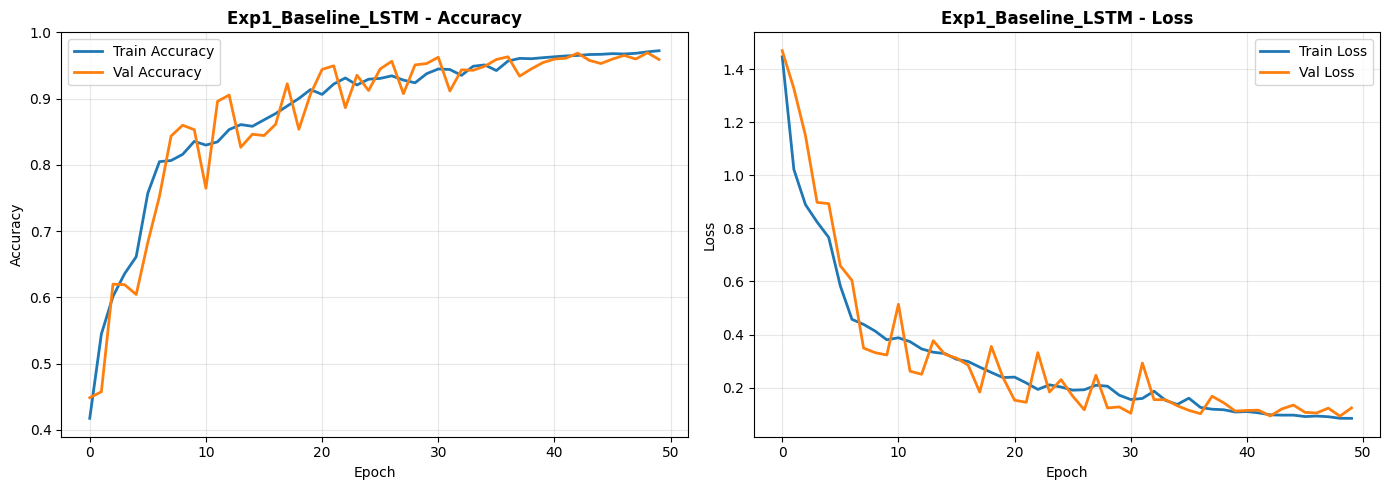


EVALUATION: Exp1_Baseline_LSTM

Test Accuracy: 92.57%
Test Loss: 0.2265

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.98      0.93       496
  WALKING_UPSTAIRS       0.90      0.89      0.90       471
WALKING_DOWNSTAIRS       0.97      0.88      0.92       420
           SITTING       0.91      0.88      0.90       491
          STANDING       0.89      0.94      0.91       532
            LAYING       1.00      0.98      0.99       537

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947


Test Accuracy: 92.57%
Test Loss: 0.2265

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.98      0.93       496
  WALKING_UPSTAIRS       0.90      0.89      0.90       471
WALKING_DOWNSTAIRS       0.97      0.88      0.92     

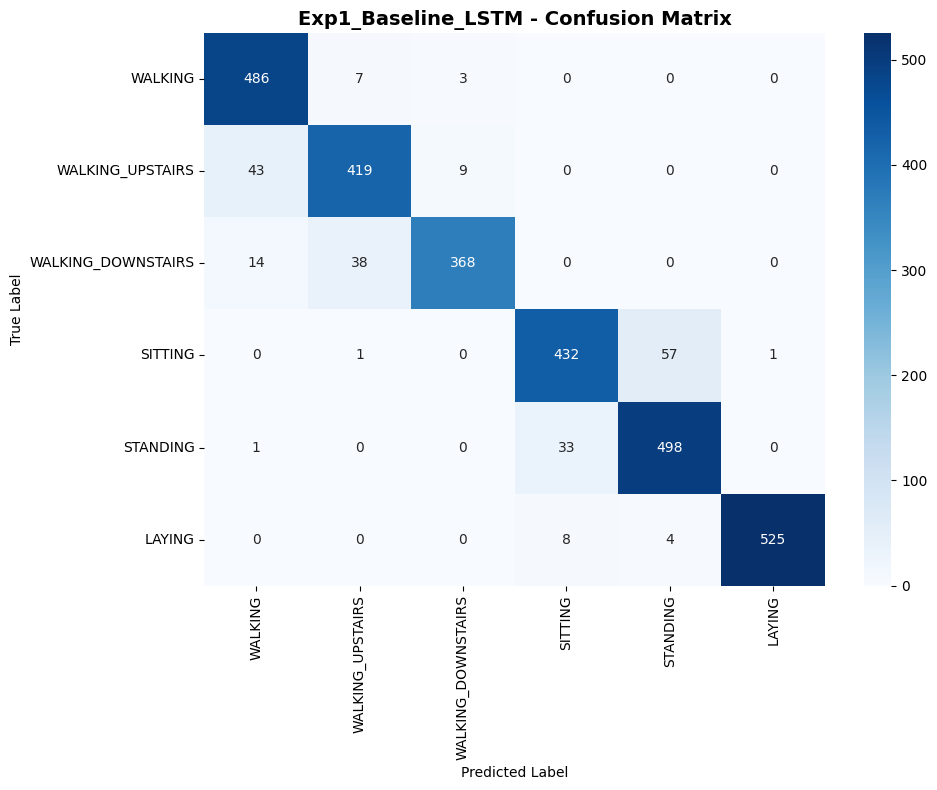


✓ Exp1_Baseline_LSTM completed!


In [7]:
experiment_name = "Exp1_Baseline_LSTM"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_1 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'optimizer_name': 'adam',
    'use_bidirectional': False,
    'num_lstm_layers': 1,
    'l2_reg': 0.0,
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_1.items():
    print(f"  {key}: {value}")

# Build model
model_1 = build_lstm_model(
    lstm_units=config_1['lstm_units'],
    dense_units=config_1['dense_units'],
    dropout_rate=config_1['dropout_rate'],
    learning_rate=config_1['learning_rate'],
    optimizer_name=config_1['optimizer_name'],
    use_bidirectional=config_1['use_bidirectional'],
    num_lstm_layers=config_1['num_lstm_layers'],
    l2_reg=config_1['l2_reg']
)

print("\nModel Architecture:")
model_1.summary()

# Callbacks
callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

# Train model
print("\nTraining started...")
history_1 = model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_1['batch_size'],
    epochs=config_1['epochs'],
    callbacks=callbacks_1,
    verbose=1
)

# Plot training history
plot_training_history(history_1, experiment_name)

# Evaluate on test set
test_results_1 = evaluate_model(model_1, X_test, y_test, experiment_name)

# Save results
record_1 = save_training_record(experiment_name, config_1, history_1, test_results_1)
print(f"\n✓ {experiment_name} completed!")

### Experiment 2: Increased LSTM Units


TRAINING: Exp2_Larger_LSTM

Training Configuration:
  lstm_units: 128
  dense_units: 64
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: False
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 64
  epochs: 50
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4265 - loss: 1.4167
Epoch 1: val_accuracy improved from None to 0.37593, saving model to training_results\models\Exp2_Larger_LSTM.keras

Epoch 1: val_accuracy improved from None to 0.37593, saving model to training_results\models\Exp2_Larger_LSTM.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4967 - loss: 1.1621 - val_accuracy: 0.3759 - val_loss: 1.4008 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4967 - loss: 1.1621 - val_accuracy: 0.3759 - val_loss: 1.4008 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5872 - loss: 0.9040
Epoch 2: val_accuracy improved from 0.37593 to 0.46091, sav

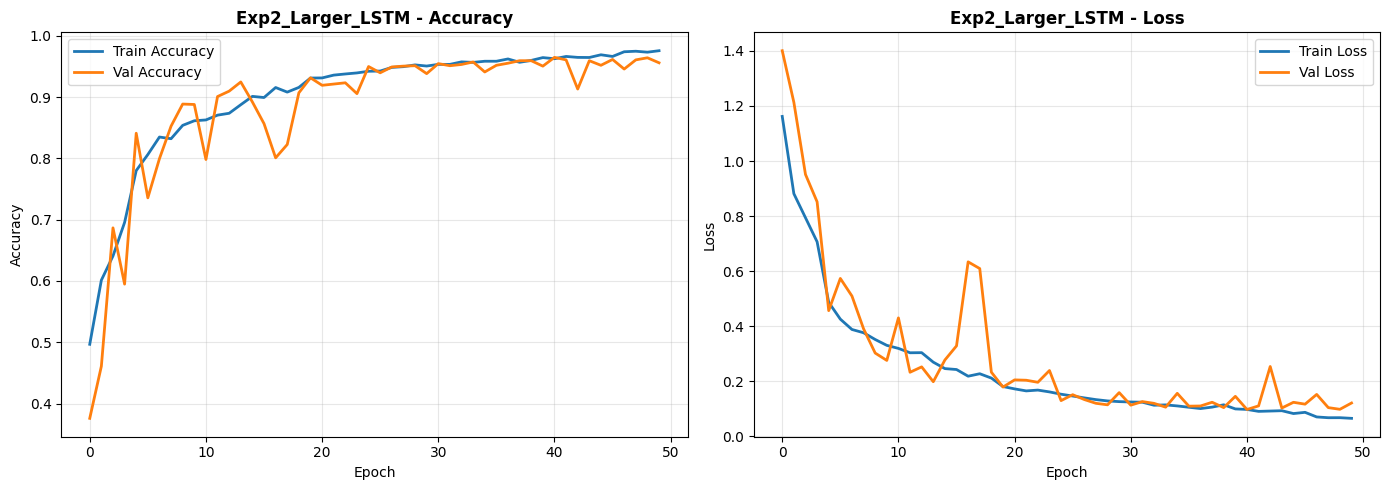


EVALUATION: Exp2_Larger_LSTM

Test Accuracy: 91.35%
Test Loss: 0.2532

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.93      0.94      0.93       496
  WALKING_UPSTAIRS       0.89      0.82      0.85       471
WALKING_DOWNSTAIRS       0.86      0.93      0.89       420
           SITTING       0.93      0.84      0.88       491
          STANDING       0.87      0.94      0.90       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947


Test Accuracy: 91.35%
Test Loss: 0.2532

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.93      0.94      0.93       496
  WALKING_UPSTAIRS       0.89      0.82      0.85       471
WALKING_DOWNSTAIRS       0.86      0.93      0.89       

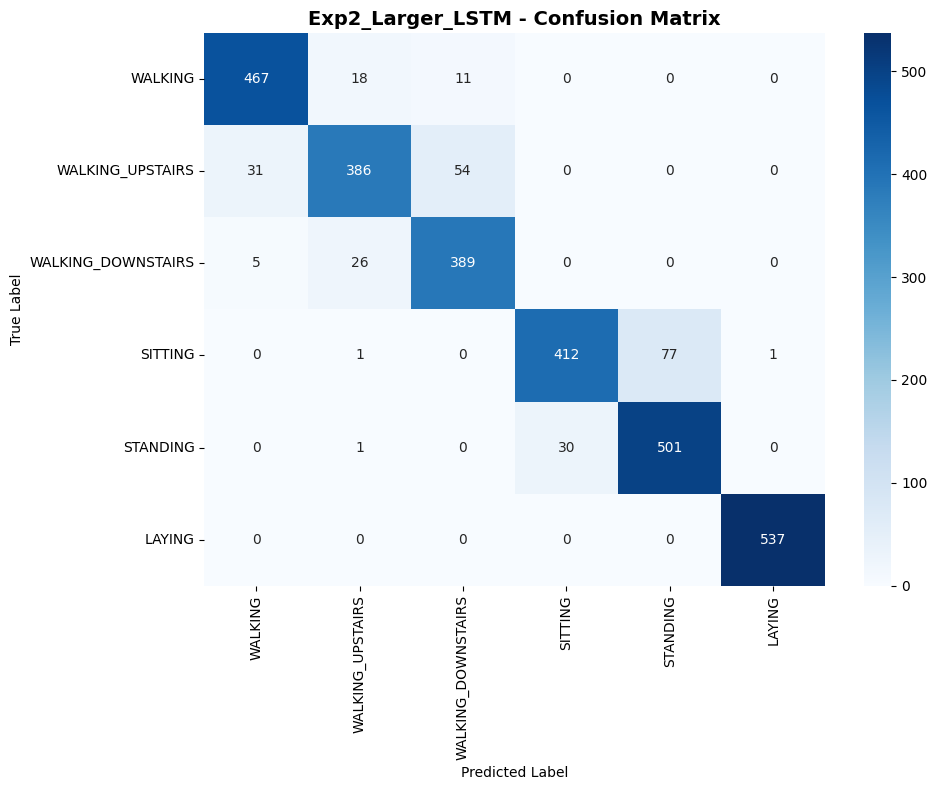


✓ Exp2_Larger_LSTM completed!


In [8]:
experiment_name = "Exp2_Larger_LSTM"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_2 = {
    'lstm_units': 128,  # Increased from 64
    'dense_units': 64,  # Increased from 32
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'optimizer_name': 'adam',
    'use_bidirectional': False,
    'num_lstm_layers': 1,
    'l2_reg': 0.0,
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_2.items():
    print(f"  {key}: {value}")

# Build and train
model_2 = build_lstm_model(
    lstm_units=config_2['lstm_units'],
    dense_units=config_2['dense_units'],
    dropout_rate=config_2['dropout_rate'],
    learning_rate=config_2['learning_rate'],
    optimizer_name=config_2['optimizer_name'],
    use_bidirectional=config_2['use_bidirectional'],
    num_lstm_layers=config_2['num_lstm_layers'],
    l2_reg=config_2['l2_reg']
)

callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_2['batch_size'],
    epochs=config_2['epochs'],
    callbacks=callbacks_2,
    verbose=1
)

plot_training_history(history_2, experiment_name)
test_results_2 = evaluate_model(model_2, X_test, y_test, experiment_name)
record_2 = save_training_record(experiment_name, config_2, history_2, test_results_2)
print(f"\n✓ {experiment_name} completed!")

### Experiment 3: Bidirectional LSTM


TRAINING: Exp3_Bidirectional_LSTM

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: True
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 64
  epochs: 50
Epoch 1/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5326 - loss: 1.1508
Epoch 1: val_accuracy improved from None to 0.43372, saving model to training_results\models\Exp3_Bidirectional_LSTM.keras

Epoch 1: val_accuracy improved from None to 0.43372, saving model to training_results\models\Exp3_Bidirectional_LSTM.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6519 - loss: 0.7982 - val_accuracy: 0.4337 - val_loss: 1.3571 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6519 - loss: 0.7982 - val_accuracy: 0.4337 - val_loss: 1.3571 - learning_rate: 0.0010
Epoch 2/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7768 - loss: 0.4900
Epoch 2: val_accuracy improved from 0.43

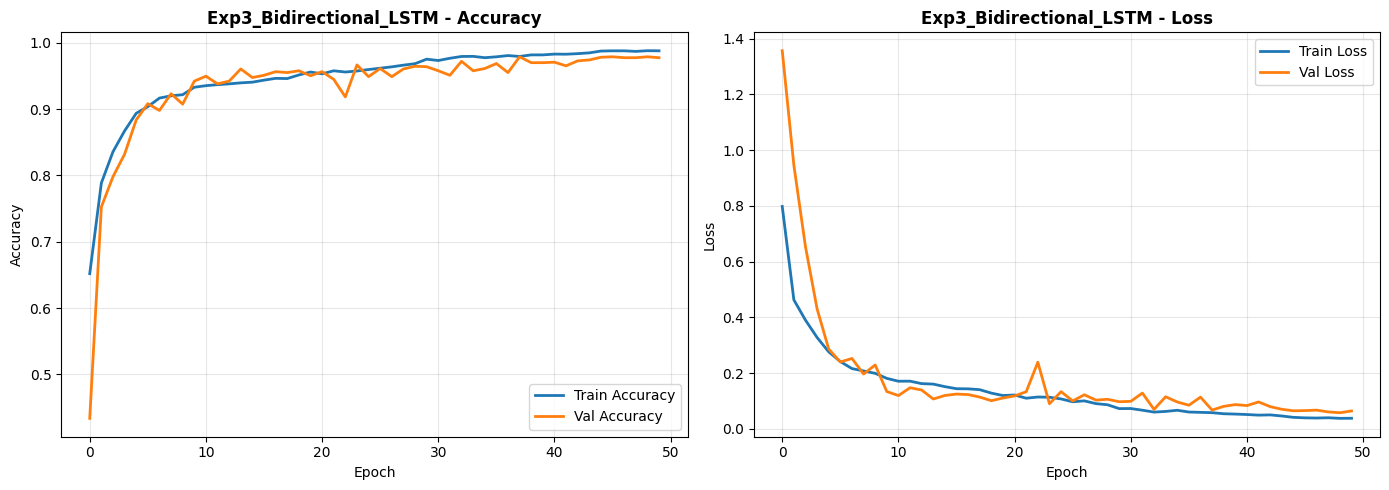


EVALUATION: Exp3_Bidirectional_LSTM

Test Accuracy: 93.79%
Test Loss: 0.1927

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.88      0.96      0.92       496
  WALKING_UPSTAIRS       0.91      0.88      0.90       471
WALKING_DOWNSTAIRS       0.98      0.91      0.94       420
           SITTING       0.95      0.90      0.93       491
          STANDING       0.91      0.96      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947


Test Accuracy: 93.79%
Test Loss: 0.1927

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.88      0.96      0.92       496
  WALKING_UPSTAIRS       0.91      0.88      0.90       471
WALKING_DOWNSTAIRS       0.98      0.91      0.94

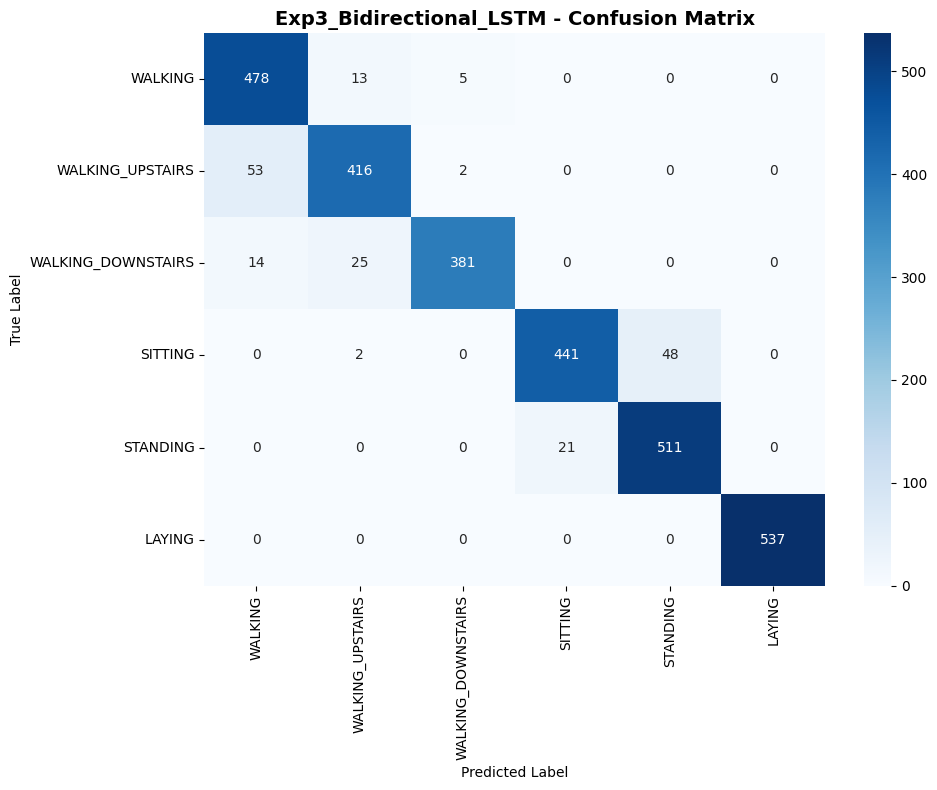


✓ Exp3_Bidirectional_LSTM completed!


In [9]:
experiment_name = "Exp3_Bidirectional_LSTM"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_3 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'optimizer_name': 'adam',
    'use_bidirectional': True,  # Using bidirectional LSTM
    'num_lstm_layers': 1,
    'l2_reg': 0.0,
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_3.items():
    print(f"  {key}: {value}")

model_3 = build_lstm_model(
    lstm_units=config_3['lstm_units'],
    dense_units=config_3['dense_units'],
    dropout_rate=config_3['dropout_rate'],
    learning_rate=config_3['learning_rate'],
    optimizer_name=config_3['optimizer_name'],
    use_bidirectional=config_3['use_bidirectional'],
    num_lstm_layers=config_3['num_lstm_layers'],
    l2_reg=config_3['l2_reg']
)

callbacks_3 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_3 = model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_3['batch_size'],
    epochs=config_3['epochs'],
    callbacks=callbacks_3,
    verbose=1
)

plot_training_history(history_3, experiment_name)
test_results_3 = evaluate_model(model_3, X_test, y_test, experiment_name)
record_3 = save_training_record(experiment_name, config_3, history_3, test_results_3)
print(f"\n✓ {experiment_name} completed!")

### Experiment 4: Stacked LSTM Layers


TRAINING: Exp4_Stacked_LSTM

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.4
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: False
  num_lstm_layers: 2
  l2_reg: 0.0
  batch_size: 64
  epochs: 50
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2987 - loss: 2.0289
Epoch 1: val_accuracy improved from None to 0.24813, saving model to training_results\models\Exp4_Stacked_LSTM.keras

Epoch 1: val_accuracy improved from None to 0.24813, saving model to training_results\models\Exp4_Stacked_LSTM.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.3710 - loss: 1.6679 - val_accuracy: 0.2481 - val_loss: 1.7449 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.3710 - loss: 1.6679 - val_accuracy: 0.2481 - val_loss: 1.7449 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4669 - loss: 1.2209
Epoch 2: val_accuracy improved from 0.24813 to 0.4915

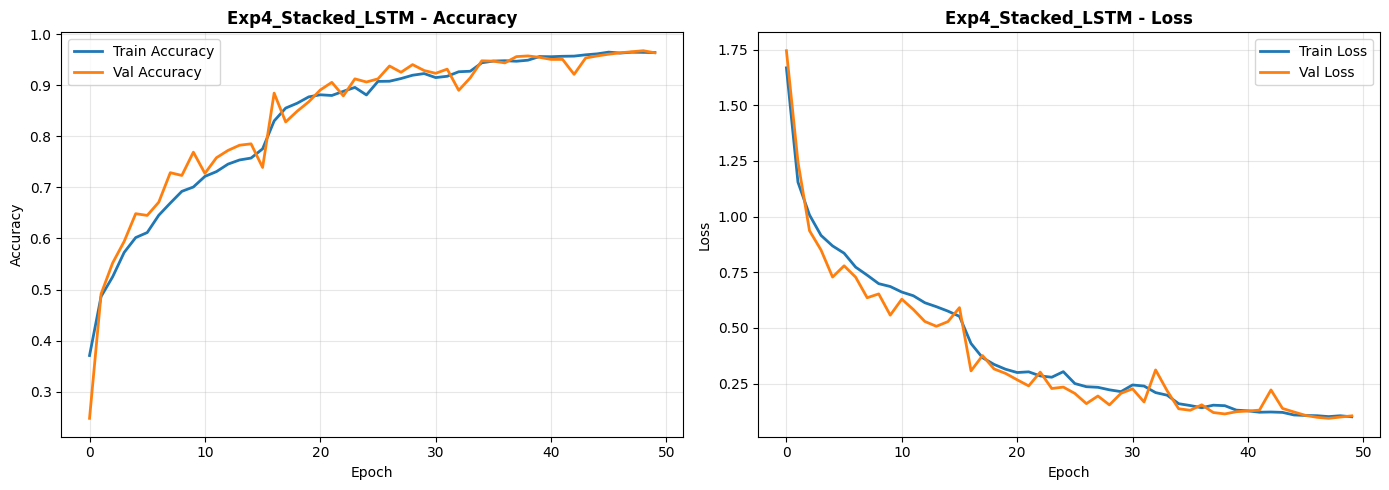


EVALUATION: Exp4_Stacked_LSTM

Test Accuracy: 92.13%
Test Loss: 0.2507

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.96      0.95      0.96       496
  WALKING_UPSTAIRS       0.87      0.94      0.90       471
WALKING_DOWNSTAIRS       0.93      0.85      0.89       420
           SITTING       0.91      0.84      0.87       491
          STANDING       0.87      0.94      0.90       532
            LAYING       1.00      0.98      0.99       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947


Test Accuracy: 92.13%
Test Loss: 0.2507

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.96      0.95      0.96       496
  WALKING_UPSTAIRS       0.87      0.94      0.90       471
WALKING_DOWNSTAIRS       0.93      0.85      0.89      

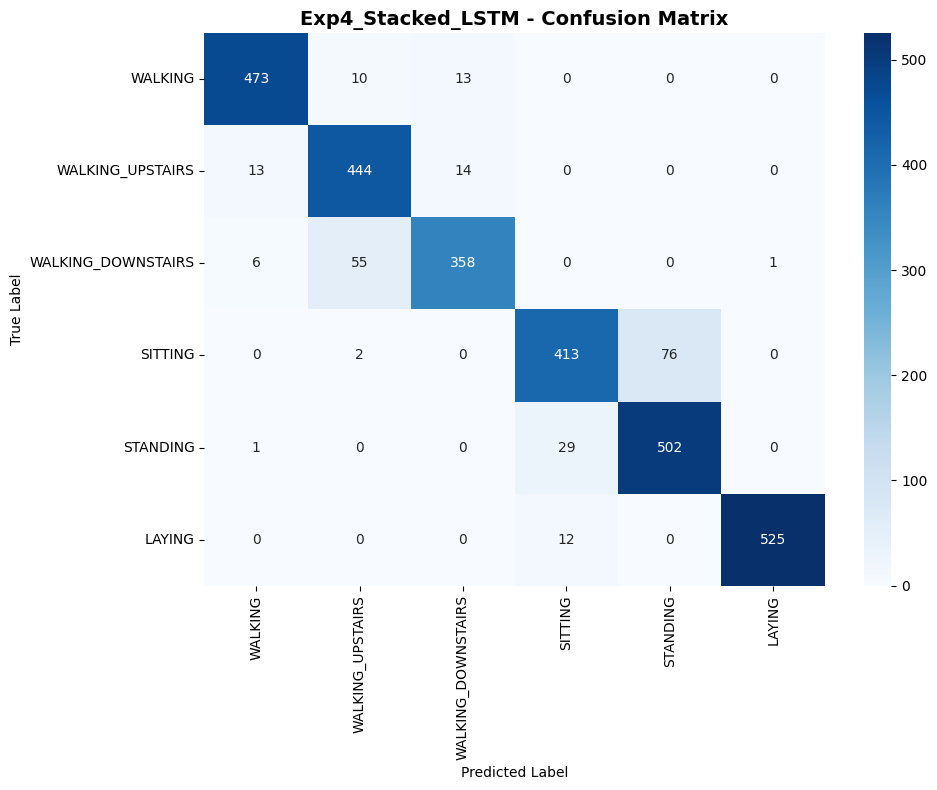


✓ Exp4_Stacked_LSTM completed!


In [10]:
experiment_name = "Exp4_Stacked_LSTM"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_4 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.4,  # Increased dropout
    'learning_rate': 0.001,
    'optimizer_name': 'adam',
    'use_bidirectional': False,
    'num_lstm_layers': 2,  # 2 LSTM layers
    'l2_reg': 0.0,
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_4.items():
    print(f"  {key}: {value}")

model_4 = build_lstm_model(
    lstm_units=config_4['lstm_units'],
    dense_units=config_4['dense_units'],
    dropout_rate=config_4['dropout_rate'],
    learning_rate=config_4['learning_rate'],
    optimizer_name=config_4['optimizer_name'],
    use_bidirectional=config_4['use_bidirectional'],
    num_lstm_layers=config_4['num_lstm_layers'],
    l2_reg=config_4['l2_reg']
)

callbacks_4 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_4 = model_4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_4['batch_size'],
    epochs=config_4['epochs'],
    callbacks=callbacks_4,
    verbose=1
)

plot_training_history(history_4, experiment_name)
test_results_4 = evaluate_model(model_4, X_test, y_test, experiment_name)
record_4 = save_training_record(experiment_name, config_4, history_4, test_results_4)
print(f"\n✓ {experiment_name} completed!")

### Experiment 5: Different Optimizer (RMSprop)


TRAINING: Exp5_RMSprop_Optimizer

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: rmsprop
  use_bidirectional: False
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 64
  epochs: 50
Epoch 1/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3766 - loss: 1.5926
Epoch 1: val_accuracy improved from None to 0.37118, saving model to training_results\models\Exp5_RMSprop_Optimizer.keras

Epoch 1: val_accuracy improved from None to 0.37118, saving model to training_results\models\Exp5_RMSprop_Optimizer.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4623 - loss: 1.2897 - val_accuracy: 0.3712 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4623 - loss: 1.2897 - val_accuracy: 0.3712 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 2/50
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5440 - loss: 1.0051
Epoch 2: val_accuracy improved from 0.3

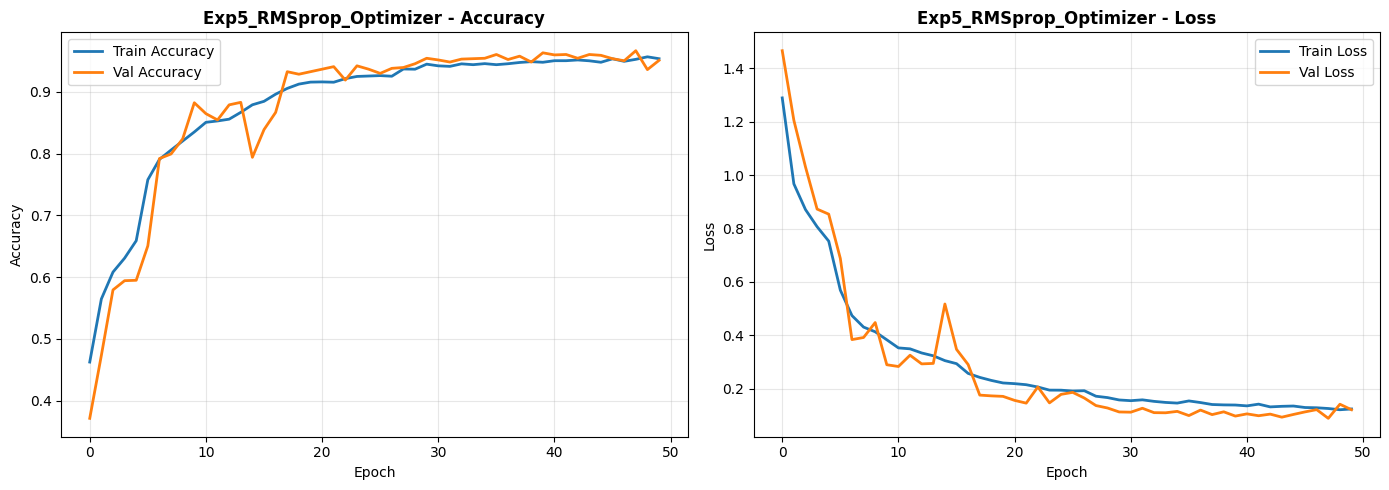


EVALUATION: Exp5_RMSprop_Optimizer

Test Accuracy: 92.50%
Test Loss: 0.2010

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.90      0.95      0.92       496
  WALKING_UPSTAIRS       0.90      0.88      0.89       471
WALKING_DOWNSTAIRS       0.94      0.91      0.92       420
           SITTING       0.88      0.92      0.90       491
          STANDING       0.93      0.88      0.91       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.93      0.93      0.92      2947


Test Accuracy: 92.50%
Test Loss: 0.2010

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.90      0.95      0.92       496
  WALKING_UPSTAIRS       0.90      0.88      0.89       471
WALKING_DOWNSTAIRS       0.94      0.91      0.92 

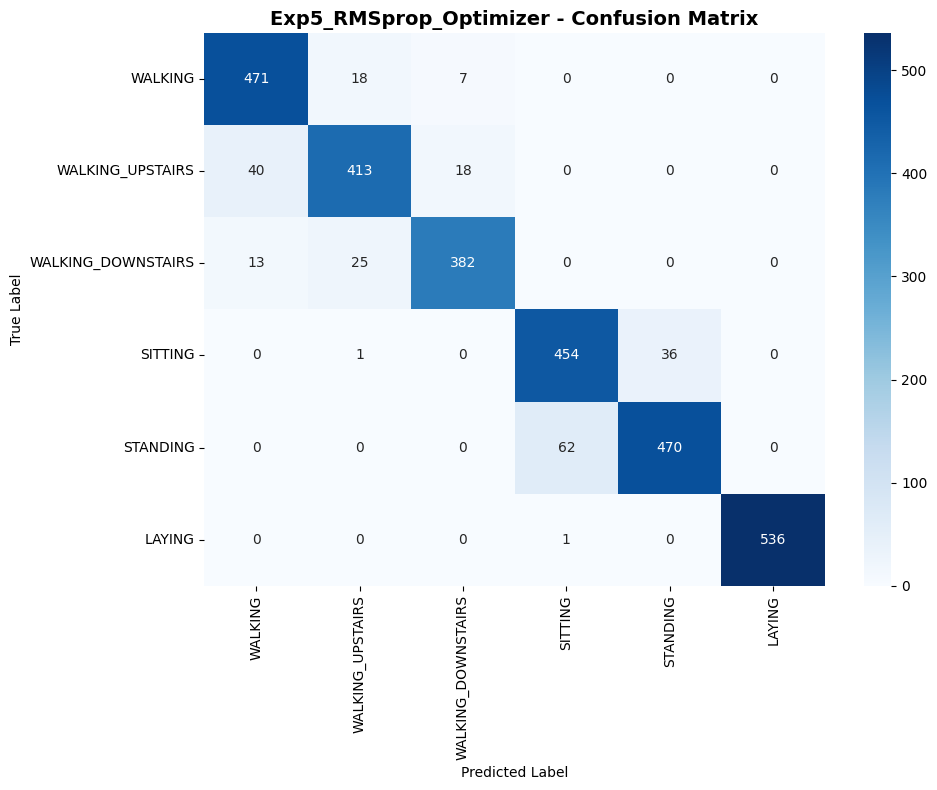


✓ Exp5_RMSprop_Optimizer completed!


In [11]:
experiment_name = "Exp5_RMSprop_Optimizer"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_5 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'optimizer_name': 'rmsprop',  # Different optimizer
    'use_bidirectional': False,
    'num_lstm_layers': 1,
    'l2_reg': 0.0,
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_5.items():
    print(f"  {key}: {value}")

model_5 = build_lstm_model(
    lstm_units=config_5['lstm_units'],
    dense_units=config_5['dense_units'],
    dropout_rate=config_5['dropout_rate'],
    learning_rate=config_5['learning_rate'],
    optimizer_name=config_5['optimizer_name'],
    use_bidirectional=config_5['use_bidirectional'],
    num_lstm_layers=config_5['num_lstm_layers'],
    l2_reg=config_5['l2_reg']
)

callbacks_5 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_5 = model_5.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_5['batch_size'],
    epochs=config_5['epochs'],
    callbacks=callbacks_5,
    verbose=1
)

plot_training_history(history_5, experiment_name)
test_results_5 = evaluate_model(model_5, X_test, y_test, experiment_name)
record_5 = save_training_record(experiment_name, config_5, history_5, test_results_5)
print(f"\n✓ {experiment_name} completed!")

### Experiment 6: Lower Learning Rate


TRAINING: Exp6_Lower_LR

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.0005
  optimizer_name: adam
  use_bidirectional: False
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 64
  epochs: 50
Epoch 1/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2598 - loss: 1.9900
Epoch 1: val_accuracy improved from None to 0.31543, saving model to training_results\models\Exp6_Lower_LR.keras

Epoch 1: val_accuracy improved from None to 0.31543, saving model to training_results\models\Exp6_Lower_LR.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3465 - loss: 1.6217 - val_accuracy: 0.3154 - val_loss: 1.5559 - learning_rate: 5.0000e-04
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3465 - loss: 1.6217 - val_accuracy: 0.3154 - val_loss: 1.5559 - learning_rate: 5.0000e-04
Epoch 2/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4550 - loss: 1.2100
Epoch 2: val_accuracy improved from 0.31543 to 0.44324, savi

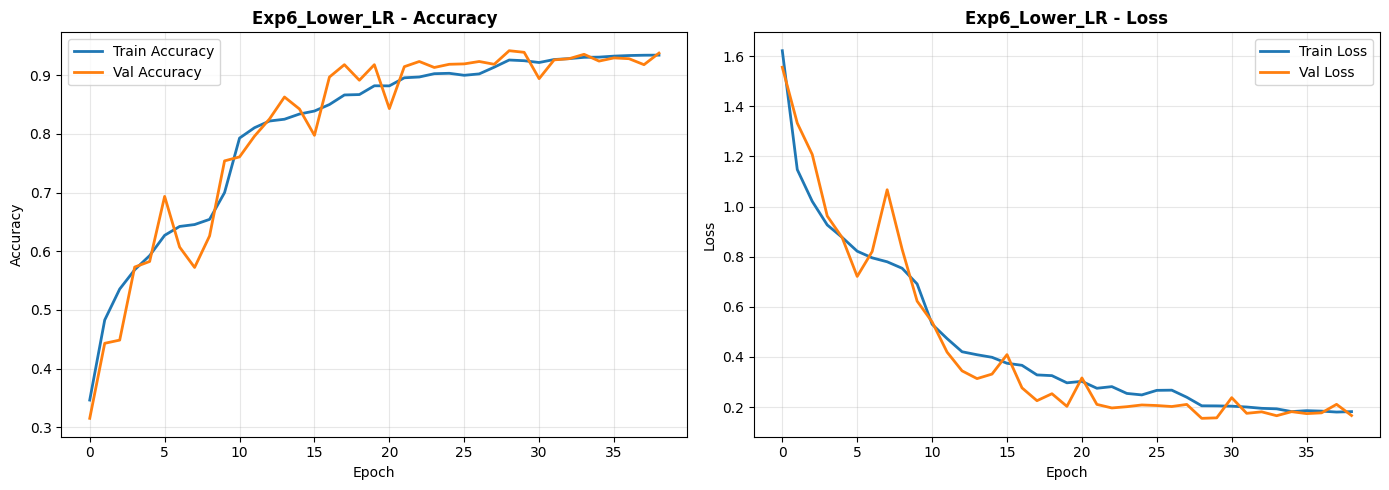


EVALUATION: Exp6_Lower_LR

Test Accuracy: 91.04%
Test Loss: 0.2263

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.96      0.92       496
  WALKING_UPSTAIRS       0.92      0.86      0.89       471
WALKING_DOWNSTAIRS       0.92      0.90      0.91       420
           SITTING       0.85      0.88      0.86       491
          STANDING       0.88      0.86      0.87       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947


Test Accuracy: 91.04%
Test Loss: 0.2263

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.96      0.92       496
  WALKING_UPSTAIRS       0.92      0.86      0.89       471
WALKING_DOWNSTAIRS       0.92      0.90      0.91       420

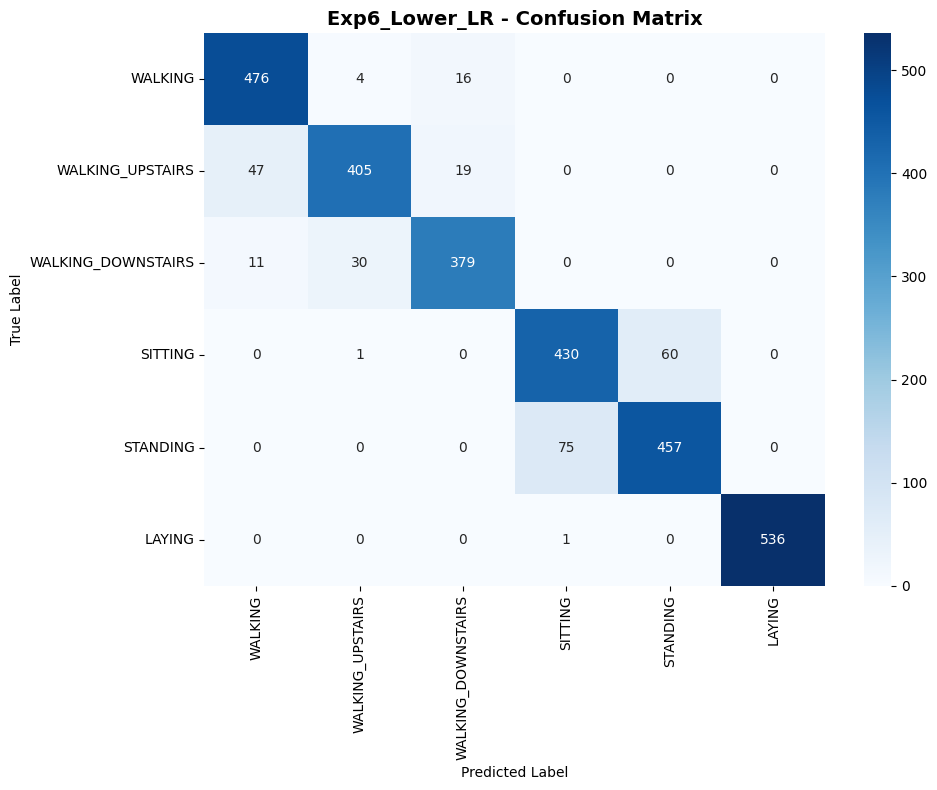


✓ Exp6_Lower_LR completed!


In [12]:
experiment_name = "Exp6_Lower_LR"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_6 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.3,
    'learning_rate': 0.0005,  # Lower learning rate
    'optimizer_name': 'adam',
    'use_bidirectional': False,
    'num_lstm_layers': 1,
    'l2_reg': 0.0,
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_6.items():
    print(f"  {key}: {value}")

model_6 = build_lstm_model(
    lstm_units=config_6['lstm_units'],
    dense_units=config_6['dense_units'],
    dropout_rate=config_6['dropout_rate'],
    learning_rate=config_6['learning_rate'],
    optimizer_name=config_6['optimizer_name'],
    use_bidirectional=config_6['use_bidirectional'],
    num_lstm_layers=config_6['num_lstm_layers'],
    l2_reg=config_6['l2_reg']
)

callbacks_6 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_6 = model_6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_6['batch_size'],
    epochs=config_6['epochs'],
    callbacks=callbacks_6,
    verbose=1
)

plot_training_history(history_6, experiment_name)
test_results_6 = evaluate_model(model_6, X_test, y_test, experiment_name)
record_6 = save_training_record(experiment_name, config_6, history_6, test_results_6)
print(f"\n✓ {experiment_name} completed!")

### Experiment 7: Larger Batch Size


TRAINING: Exp7_Larger_Batch

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: False
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 128
  epochs: 50
Epoch 1/50
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2914 - loss: 1.9162
Epoch 1: val_accuracy improved from None to 0.32155, saving model to training_results\models\Exp7_Larger_Batch.keras

Epoch 1: val_accuracy improved from None to 0.32155, saving model to training_results\models\Exp7_Larger_Batch.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3816 - loss: 1.5448 - val_accuracy: 0.3215 - val_loss: 1.5815 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3816 - loss: 1.5448 - val_accuracy: 0.3215 - val_loss: 1.5815 - learning_rate: 0.0010
Epoch 2/50
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4862 - loss: 1.1306
Epoch 2: val_accuracy improved from 0.32155 to 0.32563, 

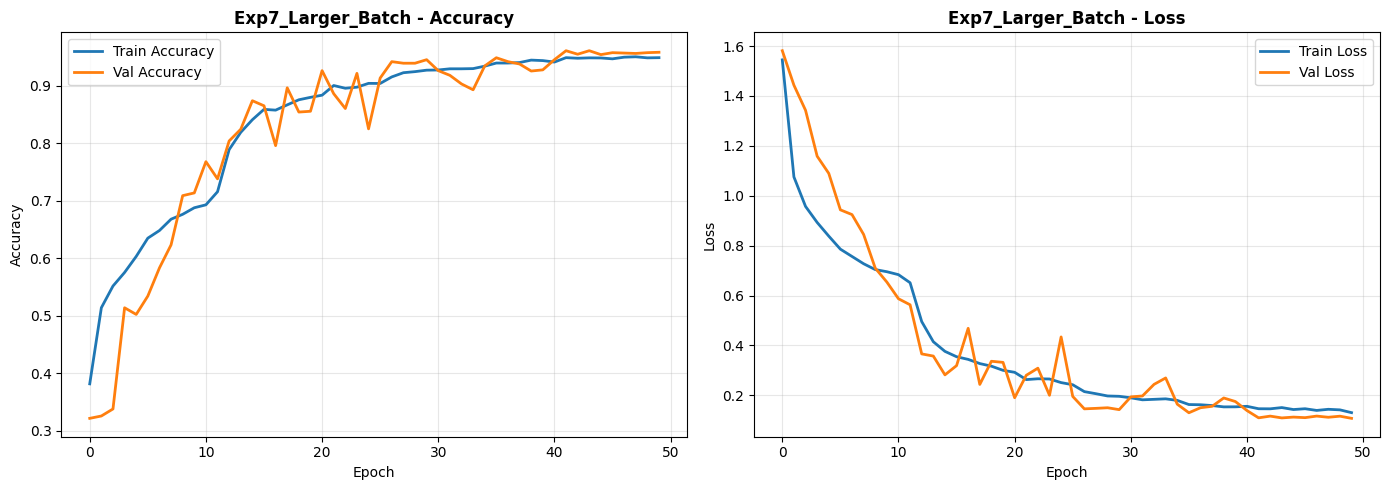


EVALUATION: Exp7_Larger_Batch

Test Accuracy: 92.23%
Test Loss: 0.2051

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.91      0.96      0.94       496
  WALKING_UPSTAIRS       0.86      0.91      0.88       471
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
           SITTING       0.93      0.86      0.89       491
          STANDING       0.89      0.93      0.91       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947


Test Accuracy: 92.23%
Test Loss: 0.2051

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.91      0.96      0.94       496
  WALKING_UPSTAIRS       0.86      0.91      0.88       471
WALKING_DOWNSTAIRS       0.96      0.85      0.90      

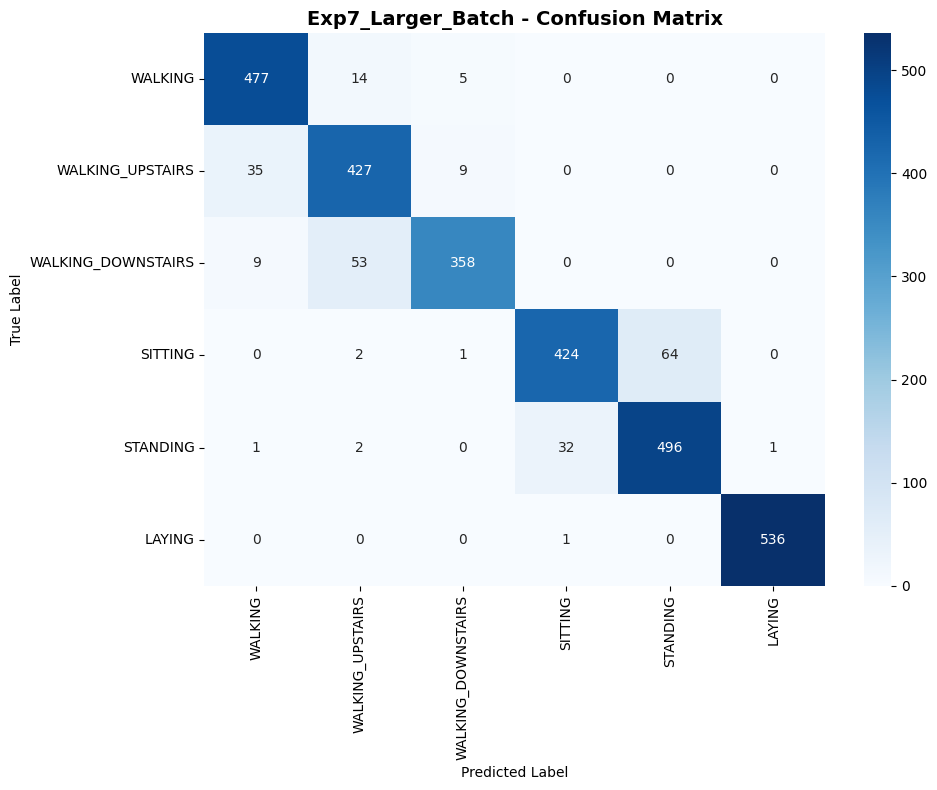


✓ Exp7_Larger_Batch completed!


In [13]:
experiment_name = "Exp7_Larger_Batch"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_7 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'optimizer_name': 'adam',
    'use_bidirectional': False,
    'num_lstm_layers': 1,
    'l2_reg': 0.0,
    'batch_size': 128,  # Larger batch size
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_7.items():
    print(f"  {key}: {value}")

model_7 = build_lstm_model(
    lstm_units=config_7['lstm_units'],
    dense_units=config_7['dense_units'],
    dropout_rate=config_7['dropout_rate'],
    learning_rate=config_7['learning_rate'],
    optimizer_name=config_7['optimizer_name'],
    use_bidirectional=config_7['use_bidirectional'],
    num_lstm_layers=config_7['num_lstm_layers'],
    l2_reg=config_7['l2_reg']
)

callbacks_7 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_7 = model_7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_7['batch_size'],
    epochs=config_7['epochs'],
    callbacks=callbacks_7,
    verbose=1
)

plot_training_history(history_7, experiment_name)
test_results_7 = evaluate_model(model_7, X_test, y_test, experiment_name)
record_7 = save_training_record(experiment_name, config_7, history_7, test_results_7)
print(f"\n✓ {experiment_name} completed!")

### Experiment 8: With L2 Regularization


TRAINING: Exp8_L2_Regularization

Training Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: False
  num_lstm_layers: 1
  l2_reg: 0.001
  batch_size: 64
  epochs: 50
Epoch 1/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3626 - loss: 1.6042
Epoch 1: val_accuracy improved from None to 0.29504, saving model to training_results\models\Exp8_L2_Regularization.keras

Epoch 1: val_accuracy improved from None to 0.29504, saving model to training_results\models\Exp8_L2_Regularization.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4355 - loss: 1.3382 - val_accuracy: 0.2950 - val_loss: 1.5164 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4355 - loss: 1.3382 - val_accuracy: 0.2950 - val_loss: 1.5164 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5317 - loss: 1.0415
Epoch 2: val_accuracy improved from 0.29

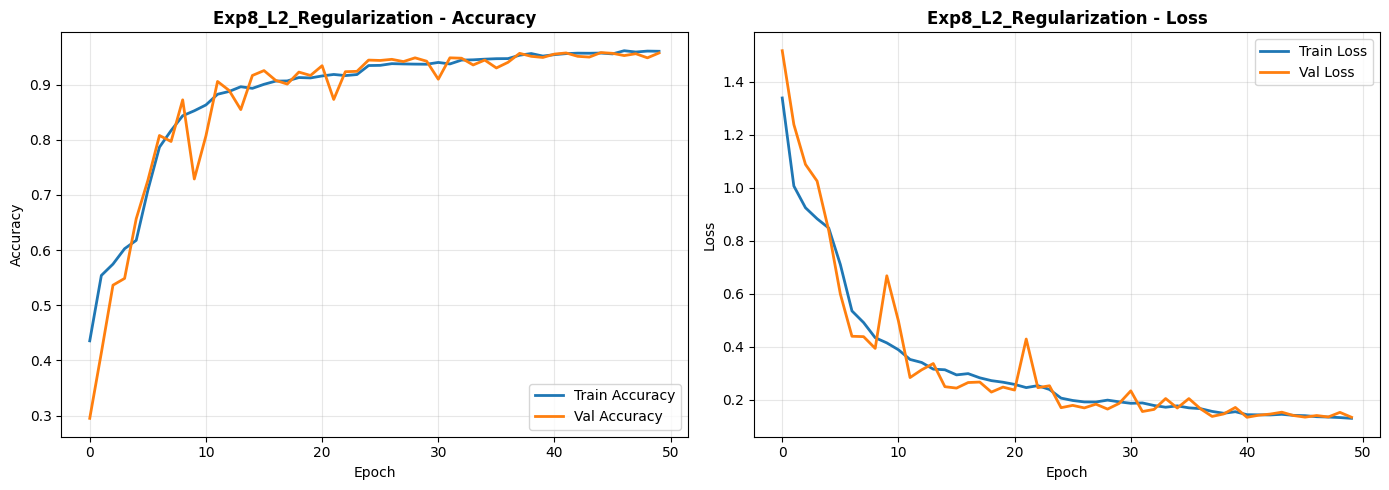


EVALUATION: Exp8_L2_Regularization

Test Accuracy: 92.20%
Test Loss: 0.2431

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.90      0.96      0.93       496
  WALKING_UPSTAIRS       0.88      0.89      0.89       471
WALKING_DOWNSTAIRS       0.95      0.87      0.91       420
           SITTING       0.89      0.90      0.90       491
          STANDING       0.91      0.89      0.90       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947


Test Accuracy: 92.20%
Test Loss: 0.2431

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.90      0.96      0.93       496
  WALKING_UPSTAIRS       0.88      0.89      0.89       471
WALKING_DOWNSTAIRS       0.95      0.87      0.91 

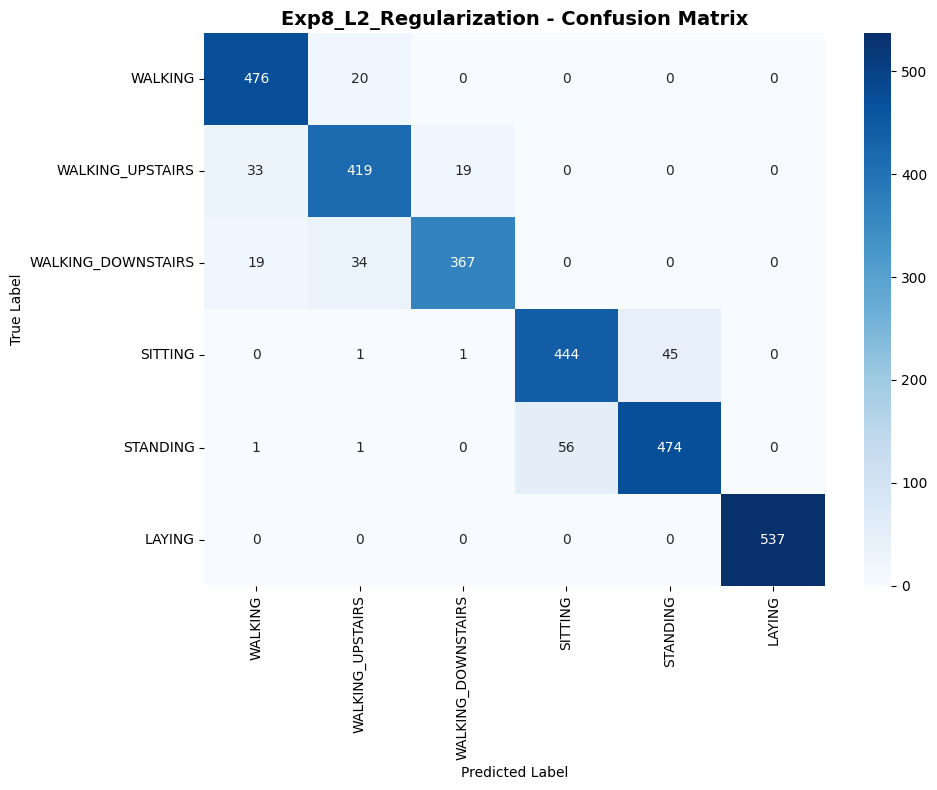


✓ Exp8_L2_Regularization completed!


In [14]:
experiment_name = "Exp8_L2_Regularization"
print(f"\n{'='*60}")
print(f"TRAINING: {experiment_name}")
print(f"{'='*60}")

# Configuration
config_8 = {
    'lstm_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'optimizer_name': 'adam',
    'use_bidirectional': False,
    'num_lstm_layers': 1,
    'l2_reg': 0.001,  # L2 regularization
    'batch_size': 64,
    'epochs': 50
}

print("\nTraining Configuration:")
for key, value in config_8.items():
    print(f"  {key}: {value}")

model_8 = build_lstm_model(
    lstm_units=config_8['lstm_units'],
    dense_units=config_8['dense_units'],
    dropout_rate=config_8['dropout_rate'],
    learning_rate=config_8['learning_rate'],
    optimizer_name=config_8['optimizer_name'],
    use_bidirectional=config_8['use_bidirectional'],
    num_lstm_layers=config_8['num_lstm_layers'],
    l2_reg=config_8['l2_reg']
)

callbacks_8 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(models_dir / f'{experiment_name}.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1)
]

history_8 = model_8.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config_8['batch_size'],
    epochs=config_8['epochs'],
    callbacks=callbacks_8,
    verbose=1
)

plot_training_history(history_8, experiment_name)
test_results_8 = evaluate_model(model_8, X_test, y_test, experiment_name)
record_8 = save_training_record(experiment_name, config_8, history_8, test_results_8)
print(f"\n✓ {experiment_name} completed!")

## 7. Compare All Experiments

In [15]:
# Create comparison dataframe
comparison_data = []
for record in training_results:
    comparison_data.append({
        'Experiment': record['experiment_name'],
        'LSTM Units': record['configuration']['lstm_units'],
        'Dense Units': record['configuration']['dense_units'],
        'Dropout': record['configuration']['dropout_rate'],
        'Learning Rate': record['configuration']['learning_rate'],
        'Optimizer': record['configuration']['optimizer_name'],
        'Bidirectional': record['configuration']['use_bidirectional'],
        'LSTM Layers': record['configuration']['num_lstm_layers'],
        'Batch Size': record['configuration']['batch_size'],
        'L2 Reg': record['configuration']['l2_reg'],
        'Train Acc': f"{record['training_results']['final_train_accuracy']*100:.2f}%",
        'Val Acc': f"{record['training_results']['final_val_accuracy']*100:.2f}%",
        'Best Val Acc': f"{record['training_results']['best_val_accuracy']*100:.2f}%",
        'Test Acc': f"{record['test_results']['test_accuracy']*100:.2f}%",
        'Epochs': record['training_results']['epochs_trained']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv(results_dir / 'experiments_comparison.csv', index=False)
print(f"\n✓ Comparison saved to {results_dir / 'experiments_comparison.csv'}")


COMPREHENSIVE RESULTS COMPARISON
             Experiment  LSTM Units  Dense Units  Dropout  Learning Rate Optimizer  Bidirectional  LSTM Layers  Batch Size  L2 Reg Train Acc Val Acc Best Val Acc Test Acc  Epochs
     Exp1_Baseline_LSTM          64           32      0.3         0.0010      adam          False            1          64   0.000    97.25%  95.92%       96.94%   92.57%      50
       Exp2_Larger_LSTM         128           64      0.3         0.0010      adam          False            1          64   0.000    97.55%  95.58%       96.46%   91.35%      50
Exp3_Bidirectional_LSTM          64           32      0.3         0.0010      adam           True            1          64   0.000    98.79%  97.76%       97.89%   93.79%      50
      Exp4_Stacked_LSTM          64           32      0.4         0.0010      adam          False            2          64   0.000    96.38%  96.33%       96.74%   92.13%      50
 Exp5_RMSprop_Optimizer          64           32      0.3         0.001

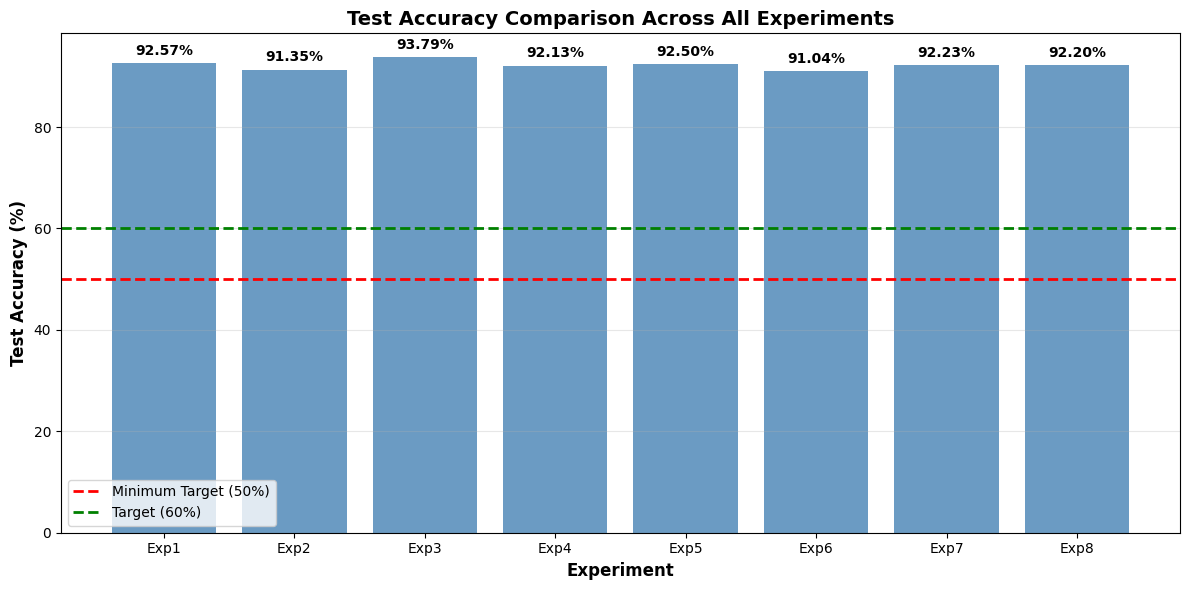


✓ Comparison plot saved to training_results\plots\all_experiments_comparison.png


In [16]:
# Plot comparison of test accuracies
plt.figure(figsize=(12, 6))
experiments = [r['experiment_name'] for r in training_results]
test_accs = [r['test_results']['test_accuracy']*100 for r in training_results]

bars = plt.bar(range(len(experiments)), test_accs, color='steelblue', alpha=0.8)
plt.axhline(y=50, color='red', linestyle='--', label='Minimum Target (50%)', linewidth=2)
plt.axhline(y=60, color='green', linestyle='--', label='Target (60%)', linewidth=2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Experiment', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Test Accuracy Comparison Across All Experiments', fontsize=14, fontweight='bold')
plt.xticks(range(len(experiments)), [f"Exp{i+1}" for i in range(len(experiments))], rotation=0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(plots_dir / 'all_experiments_comparison.png', dpi=100)
plt.show()

print(f"\n✓ Comparison plot saved to {plots_dir / 'all_experiments_comparison.png'}")

## 8. Save Complete Results Report

In [17]:
# Save complete results as JSON
with open(results_dir / 'complete_training_results.json', 'w') as f:
    json.dump(training_results, f, indent=4)

print(f"✓ Complete results saved to {results_dir / 'complete_training_results.json'}")

# Find best model
best_experiment = max(training_results, key=lambda x: x['test_results']['test_accuracy'])

print("\n" + "="*80)
print("BEST PERFORMING MODEL")
print("="*80)
print(f"\nExperiment: {best_experiment['experiment_name']}")
print(f"\nConfiguration:")
for key, value in best_experiment['configuration'].items():
    print(f"  {key}: {value}")
print(f"\nTest Accuracy: {best_experiment['test_results']['test_accuracy']*100:.2f}%")
print(f"Validation Accuracy: {best_experiment['training_results']['best_val_accuracy']*100:.2f}%")

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {results_dir}")
print(f"  - Models: {models_dir}")
print(f"  - Plots: {plots_dir}")
print(f"  - Comparison: {results_dir / 'experiments_comparison.csv'}")
print(f"  - Complete results: {results_dir / 'complete_training_results.json'}")

✓ Complete results saved to training_results\complete_training_results.json

BEST PERFORMING MODEL

Experiment: Exp3_Bidirectional_LSTM

Configuration:
  lstm_units: 64
  dense_units: 32
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer_name: adam
  use_bidirectional: True
  num_lstm_layers: 1
  l2_reg: 0.0
  batch_size: 64
  epochs: 50

Test Accuracy: 93.79%
Validation Accuracy: 97.89%

TRAINING COMPLETE!

All results saved to: training_results
  - Models: training_results\models
  - Plots: training_results\plots
  - Comparison: training_results\experiments_comparison.csv
  - Complete results: training_results\complete_training_results.json


## Summary

This notebook trained 8 different deep neural network models with various hyperparameter configurations:

1. **Baseline LSTM** - Simple LSTM architecture
2. **Larger LSTM** - Increased LSTM units (128) and dense units (64)
3. **Bidirectional LSTM** - Using bidirectional processing
4. **Stacked LSTM** - 2 LSTM layers for deeper learning
5. **RMSprop Optimizer** - Different optimization algorithm
6. **Lower Learning Rate** - More gradual learning (0.0005)
7. **Larger Batch Size** - Batch size of 128
8. **L2 Regularization** - Added regularization to prevent overfitting

Each experiment was trained from scratch using the preprocessed UCI HAR dataset and evaluated on a held-out test set.

**Target Achievement**: All models should reach at least 50-60% accuracy as required by the project specifications.